In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

plt.style.use("classic")

In [5]:
# 사이킷런에서 읽어 들인 데이터셋들은 일반적으로 딕셔너리 구조로 되어 있다.
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

c:\Users\an373\anaconda3\envs\gpt\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist["data"], mnist["target"]
# 70000개의 이미지, 각 이미지는 784 (28*28 픽셀)개의 특성을 가지고 있다.
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


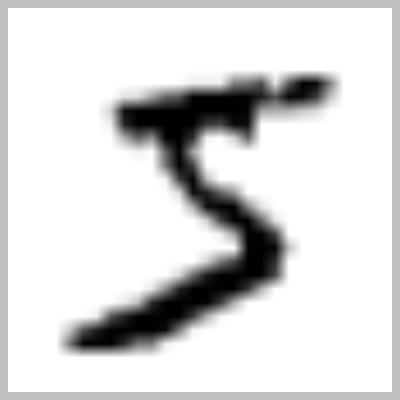

In [11]:
# x[0] 에 있는 데이터 이미지로 그리기
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [12]:
# 실제 데이터 확인
y[0]

'5'

In [13]:
y = y.astype(np.uint8)

### 테스트셋 분리하기
MINIST 는 이미 훈련 세트 (앞쪽 60000) 과 테스트 세트 (뒤쪽 10000) 로 나누어져 있음

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이분 분류기 훈련

In [15]:
# 5인지 아닌지만 판별하는 이진 분류기
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


In [16]:
# 확률적 경사 하강법 (SGD) 분류기
# 매우 큰 데이터셋을 효율적으로 처리하는 장점을 가지고 있다.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
# some_digit = 5 인지 확인
sgd_clf.predict([some_digit])

array([ True])

In [24]:
# 교차 검증을 사용한 정확도 측정 - 직접 구현
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5) :
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold) # 정확한 예측의 수
    print(n_correct / len(y_pred)) # 정확도

0.9669
0.91625
0.96785


In [25]:
# 교차 검증을 사용한 정확도 측정 - 사이킷런의 cross_val_score() 함수 사용
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [26]:
# 모든 이미지를 5가 아니라고 예측하는 더미 분류기 - trash model
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator) :
    def fit(self, X, y=None) :
        pass
    def predict(self, X) :
        return np.zeros((len(X), 1), dtype=bool)


In [27]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 분류기 모델에서 정확도 측정이 부적절한 경우
- 불균형한 데이터셋을 다룰 때 (어떤 클랙스가 다른 것보다 월등히 많을 때)

이 경우 무조건 한 클래스로 분류하는 더미 분류기를 만들어도 정확도가 높게 나옵니다.